In [44]:
import numpy as np
from itertools import product 

In [2]:
import math

In [3]:
from queue import PriorityQueue

class ReversePriorityQueue(PriorityQueue):
    def put(self, tup):
        newtup = tup[0] * -1, tup[1]
        PriorityQueue.put(self, newtup)
    def get(self):
        tup = PriorityQueue.get(self)
        newtup = tup[0] * -1, tup[1]
        return newtup

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [5]:
import pandas as pd

In [6]:
import seaborn as sns

In [7]:
def costs_linear_in_means(budget, mean_scores, base_price, coefficient):
    return np.array([min(budget, i) for i in coefficient*mean_scores + base_price])

In [8]:
def compute_test_scores(costs, budget, training_samples, obj):
    num_items = len(costs)
    num_training_samples = len(training_samples[0])
    test_scores = np.zeros(num_items)
    for i in range(num_items):
        num_tests = math.floor(budget / costs[i])
        num_batches = math.floor(num_training_samples / num_tests)
        temp_sum = 0
        for j in range(num_batches):
            if obj == "modular":
                temp_sum += np.sum(training_samples[i][j*num_tests:(j+1)*num_tests])
            elif obj == "square_root":
                temp_sum += math.sqrt(np.sum(training_samples[i][j*num_tests:(j+1)*num_tests]))
            elif obj == "max":
                temp_sum += np.max(training_samples[i][j*num_tests:(j+1)*num_tests])
            elif obj[0:4] == "top-":
                r = int(obj[4])
                temp_sum += np.sum(np.sort(training_samples[i][j*num_tests:(j+1)*num_tests])[-r:])
            elif obj[0:4] == "CES-":
                r = int(obj[4])
                temp_sum += np.power(np.sum(np.power(training_samples[i][j*num_tests:(j+1)*num_tests], r)), 1/r)
            #elif obj == "success_probability"
        test_scores[i] = temp_sum / num_batches
    return test_scores

In [9]:
def evaluate_function_value(items, test_samples, obj):
    num_itmes = len(items)
    num_test_samples = np.shape(test_samples)[1]
    temp_sum = 0
    for j in range(num_test_samples):
        if obj == "modular":
            temp_sum += np.sum(test_samples[items,j])
        elif obj == "square_root":
            temp_sum += math.sqrt(np.sum(test_samples[items,j]))
        elif obj == "max":
            temp_sum += np.max(test_samples[items,j])
        elif obj[0:4] == "top-":
            r = int(obj[4])
            temp_sum += np.sum(np.sort(test_samples[items,j])[-r:])
        elif obj[0:4] == "CES-":
            r = int(obj[4])
            temp_sum += np.power(np.sum(np.power(test_samples[items,j], r)), 1/r)       
        #elif obj == "success_probability"
    return temp_sum / num_test_samples

In [10]:
def test_score_algorithm(costs, budget, training_samples, obj):
    num_items = len(costs)
    test_scores = compute_test_scores(costs, budget, training_samples, obj)
    ranking = np.argsort(-test_scores)
    set_1 = np.array([], int)
    cost_for_1 = 0
    i = 0
    while cost_for_1 + costs[ranking[i]] <= budget:
        set_1 = np.append(set_1, ranking[i])
        cost_for_1 += costs[ranking[i]]
        i += 1
    cutoff = i
    #print(set_1, "\t\tThe first k items")
    for j in range(num_items-cutoff-1):
        if cost_for_1 + costs[ranking[j+cutoff+1]] <= budget:
            set_1 = np.append(set_1, ranking[j+cutoff+1])
            cost_for_1 += costs[ranking[j+cutoff+1]]
    #print(set_1, "\t\tS*: the first k items and more items greedily packed")
    
    set_2 = np.array([ranking[cutoff]])
    cost_for_2 = costs[ranking[cutoff]]
    for j in range(num_items):
        if j != cutoff and cost_for_2 + costs[ranking[j]] <= budget:
            set_2 = np.append(set_2, ranking[j])
            cost_for_2 += costs[ranking[j]]
    #print(set_2, "\t\tS**")
    
    set_1_value = evaluate_function_value(set_1, training_samples, obj)
    set_2_value = evaluate_function_value(set_2, training_samples, obj)
    if set_1_value >= set_2_value:
        return np.sort(set_1)
    else:
        return np.sort(set_2)

In [11]:
def lazy_forward(costs, budget, training_samples, obj, cost_type):
    num_items = len(costs)
    output = np.array([], int)
    cost = 0
    value = 0
    
    marginal_values = ReversePriorityQueue()
    for i in range(num_items):
        value_i = evaluate_function_value(np.array([i]), training_samples, obj)
        if cost_type == "unit":
            marginal_values.put((value_i, i))
        elif cost_type == "general":
            marginal_values.put((value_i/costs[i], i))
    status = np.array([("updated") for i in range(num_items)], dtype='<U16') # assumption: costs[i]<=budget for all i
    
    while not marginal_values.empty():
        (max_marginal_return, max_index) = marginal_values.get()
        if status[max_index] == "not_updated":
            new_value = evaluate_function_value(np.append(output, max_index), training_samples, obj)
            new_marginal_return = max(new_value - value, 0)
            if cost_type == "unit":
                marginal_values.put((new_marginal_return, max_index))
            elif cost_type == "general":
                marginal_values.put((new_marginal_return/costs[max_index], max_index))
            status[max_index] = "updated"
        elif status[max_index] == "updated":
            cost += costs[max_index]
            output = np.append(output, max_index)
            value = evaluate_function_value(output, training_samples, obj)
            status[max_index] == "removed"
            for i in [(i) for i in range(num_items) if status[i] != "removed"]:
                if cost + costs[i] > budget:
                    status[i] = "removed"
                else:
                    status[i] = "not_updated"
    
    #print(budget-cost)
    return output, value

In [12]:
def cost_effective_lazy_forward_KDD(costs, budget, training_samples, obj):
    set_unit_cost, set_unit_cost_value = lazy_forward(costs, budget, training_samples, obj, "unit")
    set_general_cost, set_general_cost_value = lazy_forward(costs, budget, training_samples, obj, "general")
    #print(np.sort(set_unit_cost))
    #print(np.sort(set_general_cost))
    if set_unit_cost_value >= set_general_cost_value:
        return set_unit_cost
    else:
        return np.sort(set_general_cost)
    return np.sort(set_general_cost)

# Post data
- '@PostTypeId' == 1 means a question, and 2 means an answer to a question.
- '@Score' counts the difference of the total upvotes and the total downvotes.
- '@ViewCount' counts how many times the question was visited(?).
- '@Score' / '@ViewCount' gives a measure of an user's performance.

In [13]:
import xmltodict

with open('data/academia.stackexchange.com/Posts.xml') as fd:
    posts = xmltodict.parse(fd.read())

In [14]:
dfposts = pd.DataFrame(posts['posts']['row'])
dfposts['@Score'] = pd.to_numeric(dfposts['@Score'], errors='coerce')
dfposts['@ViewCount'] = pd.to_numeric(dfposts['@ViewCount'], errors='coerce')
dfposts['@AnswerCount'] = pd.to_numeric(dfposts['@AnswerCount'], errors='coerce')
dfposts['@CommentCount'] = pd.to_numeric(dfposts['@CommentCount'], errors='coerce')
dfposts['@FavoriteCount'] = pd.to_numeric(dfposts['@FavoriteCount'], errors='coerce')
dfposts.head()

,@Id,@PostTypeId,@AcceptedAnswerId,@CreationDate,@Score,@ViewCount,@Body,@OwnerUserId,@LastEditorUserId,@LastEditDate,...,@Tags,@AnswerCount,@CommentCount,@FavoriteCount,@ContentLicense,@ClosedDate,@ParentId,@OwnerDisplayName,@CommunityOwnedDate,@LastEditorDisplayName
0,1,1,180,2012-02-14T20:23:40.127,20,532.0,<p>As from title. What kind of visa class do I...,5,2700,2013-10-30T09:14:11.633,...,<job-search><visa><japan>,2.0,1,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
1,2,1,246,2012-02-14T20:26:22.683,11,785.0,<p>Which online resources are available for jo...,5,15723,2014-09-18T13:02:01.180,...,<phd><job-search><online-resource><chemistry>,2.0,2,NaN,CC BY-SA 3.0,2015-03-29T20:06:49.947,NaN,NaN,NaN,NaN
2,3,1,6,2012-02-14T20:27:41.980,48,4754.0,<p>As from title. Not all journals provide the...,5,38446,2016-03-11T14:56:14.233,...,<journals><bibliometrics><impact-factor>,4.0,1,17.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
3,4,1,145,2012-02-14T20:29:04.737,13,294.0,<p>I have seen many engineering departments wa...,18,15723,2014-09-18T13:02:31.710,...,<job-search><united-states><engineering>,2.0,0,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN
4,5,1,9,2012-02-14T20:30:26.703,35,1078.0,"<p>What is the h-index, and how does it work ?...",5,99421,2019-01-24T15:18:25.270,...,<bibliometrics><methodology><ranking>,1.0,1,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN


# Vote data
- '@PostId' is the idea of a post; both questions and answers receive votes.
- '@VoteTypeId' shows the type of a particular vote; the list of vote types is provided below.

In [15]:
with open('data/academia.stackexchange.com/Votes.xml') as fd2:
    votes = xmltodict.parse(fd2.read())

In [16]:
dfvotes = pd.DataFrame(votes['votes']['row'])
dfvotes.head()

,@Id,@PostId,@VoteTypeId,@CreationDate,@UserId,@BountyAmount
0,1,6,2,2012-02-14T00:00:00.000,NaN,NaN
1,2,1,2,2012-02-14T00:00:00.000,NaN,NaN
2,3,6,2,2012-02-14T00:00:00.000,NaN,NaN
3,4,3,2,2012-02-14T00:00:00.000,NaN,NaN
4,5,6,2,2012-02-14T00:00:00.000,NaN,NaN


### VoteTypeId meanings
- There are 14 types of votes.
- But we only care about the upvotes that are of type 2.

Id | Name
-- | ----------------------
1  | AcceptedByOriginator
2  | UpMod
3  | DownMod
4  | Offensive
5  | Favorite
6  | Close
7  | Reopen
8  | BountyStart
9  | BountyClose
10 | Deletion
11 | Undeletion
12 | Spam
15 | ModeratorReview
16 | ApproveEditSuggestion

### Computing the total upvotes/downvotes counts for each post

In [17]:
dfupvotes = dfvotes[dfvotes['@VoteTypeId']=='2'][['@PostId', '@VoteTypeId']]
dfupvotes_count = dfupvotes.groupby('@PostId').count().reset_index()
dfupvotes_count = dfupvotes_count.rename(columns = {'@VoteTypeId' : '@UpvoteCount'})
dfdownvotes = dfvotes[dfvotes['@VoteTypeId']=='3'][['@PostId', '@VoteTypeId']]
dfdownvotes_count = dfdownvotes.groupby('@PostId').count().reset_index()
dfdownvotes_count = dfdownvotes_count.rename(columns = {'@VoteTypeId' : '@DownvoteCount'})

dfpv = dfposts.set_index('@Id').join(dfupvotes_count.set_index('@PostId')).reset_index()
dfpv = dfpv.set_index('@Id').join(dfdownvotes_count.set_index('@PostId')).reset_index()
dfpv['@UpvoteCount'] = dfpv['@UpvoteCount'].fillna(0)
dfpv['@DownvoteCount'] = dfpv['@DownvoteCount'].fillna(0)
dfpv.head()

,@Id,@PostTypeId,@AcceptedAnswerId,@CreationDate,@Score,@ViewCount,@Body,@OwnerUserId,@LastEditorUserId,@LastEditDate,...,@CommentCount,@FavoriteCount,@ContentLicense,@ClosedDate,@ParentId,@OwnerDisplayName,@CommunityOwnedDate,@LastEditorDisplayName,@UpvoteCount,@DownvoteCount
0,1,1,180,2012-02-14T20:23:40.127,20,532.0,<p>As from title. What kind of visa class do I...,5,2700,2013-10-30T09:14:11.633,...,1,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,20.0,0.0
1,2,1,246,2012-02-14T20:26:22.683,11,785.0,<p>Which online resources are available for jo...,5,15723,2014-09-18T13:02:01.180,...,2,NaN,CC BY-SA 3.0,2015-03-29T20:06:49.947,NaN,NaN,NaN,NaN,11.0,0.0
2,3,1,6,2012-02-14T20:27:41.980,48,4754.0,<p>As from title. Not all journals provide the...,5,38446,2016-03-11T14:56:14.233,...,1,17.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,48.0,0.0
3,4,1,145,2012-02-14T20:29:04.737,13,294.0,<p>I have seen many engineering departments wa...,18,15723,2014-09-18T13:02:31.710,...,0,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,13.0,0.0
4,5,1,9,2012-02-14T20:30:26.703,35,1078.0,"<p>What is the h-index, and how does it work ?...",5,99421,2019-01-24T15:18:25.270,...,1,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,36.0,1.0


### For each question, collecting the upvotes that the answers of the question received.

In [18]:
dfqa_upvote_count = dfpv[dfpv['@PostTypeId']=='2'][['@ParentId', '@UpvoteCount']]
dfqa_upvote_count = dfqa_upvote_count.groupby('@ParentId').sum()
dfqa_upvote_count = dfqa_upvote_count.reset_index().fillna(0)
dfqa_upvote_count = dfqa_upvote_count.rename(columns = {'@ParentId':'@Id_q', '@UpvoteCount':'@TotalUpvotes'})
dfqa_upvote_count.head(10)

,@Id_q,@TotalUpvotes
0,1,8.0
1,100007,2.0
2,10001,22.0
3,100010,5.0
4,100013,9.0
5,100016,1.0
6,100017,3.0
7,100020,5.0
8,100022,5.0
9,100025,6.0


### For each question, collecting the downvotes that the answers of the question received.

In [19]:
dfqa_downvote_count = dfpv[dfpv['@PostTypeId']=='2'][['@ParentId', '@DownvoteCount']]
dfqa_downvote_count = dfqa_downvote_count.groupby('@ParentId').sum()
dfqa_downvote_count = dfqa_downvote_count.reset_index().fillna(0)
dfqa_downvote_count = dfqa_downvote_count.rename(columns = {'@ParentId':'@Id_q', '@DownvoteCount':'@TotalDownvotes'})
dfqa_downvote_count.head(10)

,@Id_q,@TotalDownvotes
0,1,0.0
1,100007,0.0
2,10001,0.0
3,100010,0.0
4,100013,0.0
5,100016,0.0
6,100017,0.0
7,100020,0.0
8,100022,1.0
9,100025,0.0


# Aggregating the score and vote counts data
- '@Score_a' and '@UpvoteCount' count the score and the number of upvotes of each answer.
- '@TotalUpvotes' counts the total upvotes that the answers for each question received.
- For example, the question with '@Id_q' == 1 has two answers which received 7 and 1 upvotes, respectively, and therefore, '@TotalUpvotes' is 8.

In [20]:
dfa = dfpv[dfpv['@PostTypeId']=='2'][['@Id', '@ParentId', '@OwnerUserId', '@Score', '@UpvoteCount', '@DownvoteCount']]
dfq = dfpv[dfpv['@PostTypeId']=='1'][['@Id', '@OwnerUserId','@Score', '@ViewCount']]
dfqa = dfa.set_index('@ParentId').join(dfq.set_index('@Id'), lsuffix='_a', rsuffix='_q')
dfqa = dfqa.reset_index()
dfqa = dfqa.rename(columns = {'index' : '@Id_q', '@Id' : '@Id_a', '@Score': '@Score_a', '@ViewCount' : '@ViewCount_q'})
dfqa = dfqa.set_index('@Id_q').join(dfqa_upvote_count.set_index('@Id_q')).reset_index()
dfqa = dfqa.set_index('@Id_q').join(dfqa_downvote_count.set_index('@Id_q')).reset_index()
dfqa.head(11)

,@Id_q,@Id_a,@OwnerUserId_a,@Score_a,@UpvoteCount,@DownvoteCount,@OwnerUserId_q,@Score_q,@ViewCount_q,@TotalUpvotes,@TotalDownvotes
0,1,180,NaN,7,7.0,0.0,5,20,532.0,8.0,0.0
1,1,142492,41071,1,1.0,0.0,5,20,532.0,8.0,0.0
2,100007,100080,15949,2,2.0,0.0,73961,3,483.0,2.0,0.0
3,10001,10002,96,12,12.0,0.0,7096,13,408.0,22.0,0.0
4,10001,10017,643,10,10.0,0.0,7096,13,408.0,22.0,0.0
5,100010,100015,9553,5,5.0,0.0,65825,2,173.0,5.0,0.0
6,100013,100014,929,9,9.0,0.0,57405,4,405.0,9.0,0.0
7,100016,100116,69460,1,1.0,0.0,14140,9,246.0,1.0,0.0
8,100017,100019,53,3,3.0,0.0,73492,0,125.0,3.0,0.0
9,100020,100052,19769,5,5.0,0.0,84044,9,207.0,5.0,0.0


In [21]:
users = np.array(dfqa['@OwnerUserId_a'].dropna(how='any').unique())
num_users = users.size
users

array(['41071', '15949', '96', ..., '7090', '83973', '70893'],
      dtype=object)

# Statistics to measure the performance of individual answer.

### Notations
- $u(a,q)$ := number of upvotes for answer $a$ to question $q$ (@UpvoteCount).

- $d(a,q)$ := number of downvotes for answer $a$ to question $q$ (@DownvoteCount).

- $s(a,q)$ := score for answer $a$ to question $q$ (to be defined).

### Measures

Our model of stochastic utility maximization assumes that each user $i$ has random performance value $\xi_i$. How do we sample $\xi_i$? We assume that $\xi_i$ is realized when user $i$ submits an answer to a question and receives votes from other users. When the user submits answer $a$ to question $q$, the answer receive $u(a,q)$ upvotes and $d(a,q)$ downvotes. Then we define $s(a,q)$ as follows:

$$s(a,q)\ := \ \frac{u(a,q) + \alpha}{u(a,q)+ d(a,q) +\alpha+\beta }.$$

Here, we can interpret $\alpha$ and $\beta$ as the number _virtual_ upvotes and downvotes for an answer, respectively. We can also interpret $\alpha + \beta$ to roughly correspond to the actual number of votes for an answer needed for them to have an effect on the “score” of this answer.

We test the following values of $(\alpha,\beta)$:
1. (5, 5):$~~~~~~~$ Small balanced
2. (10, 10):$~~~~$ Medium balanced
3. (20, 20):$~~~~$ Large balanced
4. (2, 8):$~~~~~~~$ Small conservative
5. (4, 16):$~~~~~$ Medium conservative
6. (8, 32):$~~~~~$ Large conservative

(CDF of $s(a,q)$ values)

Basically, we regard $s(a,q)$ as a realization of user $i$'s performance value $\xi_i$. That means that each answer user $i$ submits gives rise to a sample of the user's random performance value $\xi_i$.

What is the justification for using the above measure of evaluating the score of an answer? We assume that the quality of answer $a$ for question $q$ is a latent variable $X_{a,q}$ with prior $\texttt{Beta}(x;\alpha,\beta)$. Individual upvote or downvote inputs are independent $\texttt{Bernoulli}$ variables with mean $X_{a,q}$, and we evaluate the posterior of $X_{a,q}$ having observed $u(a,q)$ and $d(a,q)$. This posterior is $\texttt{Beta}(x; u(a,q) + \alpha, d(a,q) + \beta)$. Then we define $s(a,q)$ to be the expected value of $X_{a,q}$ with respect to the posterior distribution:
$$s(a,q)\ := \ \mathbb{E}\left[X_{a,q}\ | \ u(a,q),d(a,q)\right]\ = \ \frac{u(a,q) + \alpha}{u(a,q)+ d(a,q) +\alpha+\beta }.$$
Here, we set $$\alpha \ = \ \beta \ = \ 10.$$

#### Previous measures

- The score normalized by the view count: $\text{'Normalized_Score_a' = '@Score_a' / '@ViewCount_q'.}$.

$$ s(a,q) \ = \ \frac{u(a,q)}{\text{The total view count of question $q$}}.$$

- The proportion of the upvotes: $\text{'Upvote_percentage_a' = '@UpvoteCount' / '@TotalUpvotes'.}$

$$ s(a,q) \ = \ \frac{u(a,q)}{\sum (u(a', q):\ a'\text{ is an answer to question $q$})}.$$

In [22]:
dfqa_stat = dfqa[['@OwnerUserId_a', '@UpvoteCount', '@DownvoteCount']]
dfqa_stat = dfqa_stat.assign(small_balanced = (dfqa['@UpvoteCount']+5)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+10))
dfqa_stat = dfqa_stat.assign(medium_balanced = (dfqa['@UpvoteCount']+10)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+20))
dfqa_stat = dfqa_stat.assign(large_balanced = (dfqa['@UpvoteCount']+20)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+40))
dfqa_stat = dfqa_stat.assign(small_conservative = (dfqa['@UpvoteCount']+2)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+10))
dfqa_stat = dfqa_stat.assign(medium_conservative = (dfqa['@UpvoteCount']+4)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+20))
dfqa_stat = dfqa_stat.assign(large_conservative = (dfqa['@UpvoteCount']+8)/(dfqa['@UpvoteCount']+dfqa['@DownvoteCount']+40))
dfqa_stat['small_balanced'] = dfqa_stat['small_balanced'].fillna(0)
dfqa_stat['medium_balanced'] = dfqa_stat['medium_balanced'].fillna(0)
dfqa_stat['large_balanced'] = dfqa_stat['large_balanced'].fillna(0)
dfqa_stat['small_conservative'] = dfqa_stat['small_conservative'].fillna(0)
dfqa_stat['medium_conservative'] = dfqa_stat['medium_conservative'].fillna(0)
dfqa_stat['large_conservative'] = dfqa_stat['large_conservative'].fillna(0)
dfqa_stat = dfqa_stat.rename(columns = {'small_balanced' : '(5, 5)', 
                                        'medium_balanced': '(10, 10)',
                                        'large_balanced': '(20, 20)',
                                        'small_conservative': '(2, 8)',
                                        'medium_conservative': '(4, 16)',
                                        'large_conservative': '(8, 32)'
                                       })
dfqa_stat.head(10)

,@OwnerUserId_a,@UpvoteCount,@DownvoteCount,"(5, 5)","(10, 10)","(20, 20)","(2, 8)","(4, 16)","(8, 32)"
0,NaN,7.0,0.0,0.705882,0.629630,0.574468,0.529412,0.407407,0.319149
1,41071,1.0,0.0,0.545455,0.523810,0.512195,0.272727,0.238095,0.219512
2,15949,2.0,0.0,0.583333,0.545455,0.523810,0.333333,0.272727,0.238095
3,96,12.0,0.0,0.772727,0.687500,0.615385,0.636364,0.500000,0.384615
4,643,10.0,0.0,0.750000,0.666667,0.600000,0.600000,0.466667,0.360000
5,9553,5.0,0.0,0.666667,0.600000,0.555556,0.466667,0.360000,0.288889
6,929,9.0,0.0,0.736842,0.655172,0.591837,0.578947,0.448276,0.346939
7,69460,1.0,0.0,0.545455,0.523810,0.512195,0.272727,0.238095,0.219512
8,53,3.0,0.0,0.615385,0.565217,0.534884,0.384615,0.304348,0.255814
9,19769,5.0,0.0,0.666667,0.600000,0.555556,0.466667,0.360000,0.288889


# Distribution of $s(a,q)$ values

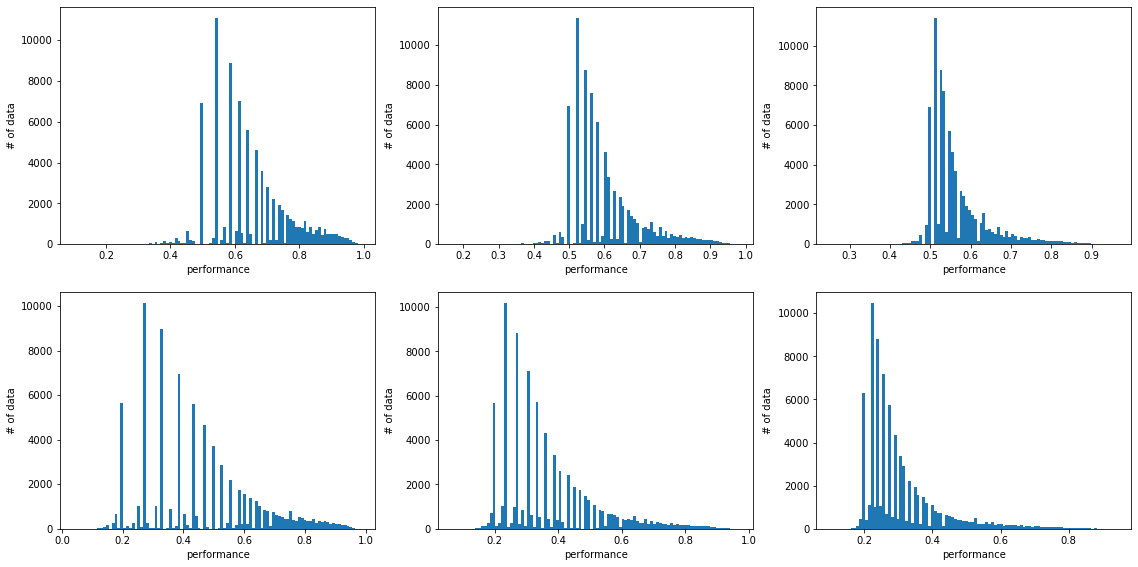

In [49]:
fig, axes = plt.subplots(2, 3, figsize = (6.4*3, 4.8*2))
axes[0,0].hist(dfqa_stat['(5, 5)'], bins=100)
axes[0,1].hist(dfqa_stat['(10, 10)'], bins=100)
axes[0,2].hist(dfqa_stat['(20, 20)'], bins=100)
axes[1,0].hist(dfqa_stat['(2, 8)'], bins=100)
axes[1,1].hist(dfqa_stat['(4, 16)'], bins=100)
axes[1,2].hist(dfqa_stat['(8, 32)'], bins=100)
for i, j in product(range(2), range(3)):
    axes[i, j].set_ylabel("# of data")
    axes[i, j].set_xlabel("performance")



# Experiment setup

- We run two kinds of experiments, depending on which performance measure is used.

#### Objectives
- The normalized score of an answer can be negative, when it receives more downvotes than upvotes.
- On the other hand, the number of upvotes is always nonnegative.
- For the normalized score, we test 'max' and 'modular' only.
- For the proportional upvotes, we test all of the four functions: 'max', 'CES-2', 'modular', 'square_root'.

#### Filtering users with enough samples
- Most users have answered very few questions.
- We set a minimum number of samples for an experiment, and collect the uses who have answered at least that number of questions.

#### Collecting samples
- We collect a certain number of samples for each user, 30 of which are separated for the test sample set and the others are used for the training sample set.
- For example, if we collect 130 samples, then 100 go to the training sample set and the other 30 go to the test sample set.
- The purpose of the training sample set is to compute the test scores of users for our TEST-GREEDY algorithm and to compute the marginal return values for the CELF algorithm (the benchmark algorithm for SFM with a knapsack constraint).
- The test sample set, containing 30 samples, is used to evaluate the value of outputs.

#### Costs
1. The mean value of an user is computed by taking the mean of the training samples.
2. Budget is set to the 30% of the summation of users' mean values.
3. Base price is defined as 
$$\frac{\text{Budget}}{30}.$$
4. We define the cost of an user $i$ as follows:
$$\text{Cost of the user} \ = \ \min\left\{\text{Budget},\quad \text{Base price}\ + \ \text{Coefficient}*\text{Mean value of the user}\right\}$$
where $\text{Coefficient}$ takes a value from
$$\left\{0,\ \frac{\text{Budget}}{10},\ \frac{2*\text{Budget}}{10},\ \frac{3*\text{Budget}}{10},\ \ldots,\ \frac{9*\text{Budget}}{10}\right\}.$$

## Creating output files

In [23]:
def create_output_files():
    column_labels_raw = ['obj', 'avg_cost', 'budget', 'avg_cost_normalized', 'setup_number', 
                         'test_number', 'num_reps',
                         'num_candidates', 'num_training_samples',  'ratio', 'num_users_TSG', 'num_users_CELF',
                         'alpha', 'beta']
    df_raw = pd.DataFrame(columns=column_labels_raw)
    df_raw.to_csv('results/results_raw_data.csv', index=False)

In [31]:
#create_output_files()

## Running experiments

In [26]:
def test_linear_cost(samples, sample_sizes, num_training_samples, obj, num_reps, num_setups, alpha, beta): 
    df = pd.read_csv('results/results_raw_data.csv')
        
    num_test_samples = 30
    num_samples = num_training_samples + num_test_samples
    candidates = np.array([i for i in range(num_users) if sample_sizes[i] >= num_samples])
     
    print('(# of training samples, # of candidates):\t(', num_training_samples, ', ', candidates.size, ')')    
        
    for i in range(num_setups):
        for j in range(num_reps):
            samples_first_candidate = np.random.choice(samples[candidates[0]], num_samples, replace=False)
            training_samples = np.array([samples_first_candidate[:num_training_samples]])
            test_samples = np.array([samples_first_candidate[num_training_samples:]])
            for l in candidates[1:]:
                samples_l = np.random.choice(samples[l], num_samples, replace=False)
                training_samples = np.append(training_samples, np.array([samples_l[:num_training_samples]]), axis=0)
                test_samples = np.append(test_samples, np.array([samples_l[num_training_samples:]]), axis=0)
            
            mean_scores = np.array([np.mean(training_samples[l]) for l in range(candidates.size)])
            mean_scores_sum = np.sum(mean_scores)
            budget = 0.3 * mean_scores_sum
            base_price = budget/30
            global_mean_score = np.mean(mean_scores)
        
            coeff = i*budget/num_setups
            avg_cost = base_price + coeff*global_mean_score
            costs = costs_linear_in_means(budget, mean_scores, base_price, coeff)
               
            output_TSG = test_score_algorithm(costs, budget, training_samples, obj)
            value_TSG = evaluate_function_value(output_TSG, test_samples, obj)
            output_CELF = cost_effective_lazy_forward_KDD(costs, budget, training_samples, obj)
            value_CELF = evaluate_function_value(output_CELF, test_samples, obj)
            df = df.append({'obj': obj, 'avg_cost': avg_cost, 'budget': budget, 
                            'avg_cost_normalized': avg_cost/budget,'setup_number': i+1,
                            'test_number': j+1, 'num_reps': num_reps,
                            'num_candidates': candidates.size, 'num_training_samples': num_training_samples, 
                            'ratio': value_TSG/value_CELF,
                            'num_users_TSG': output_TSG.size,
                            'num_users_CELF': output_CELF.size,
                            'alpha': alpha,
                            'beta': beta
                           }, ignore_index = True)
    #print(df)        
    df.to_csv('results/results_raw_data.csv', index=False)

In [29]:
training_sample_sizes = [50, 100, 150, 200, 250]
objs = ['max', 'modular', 'CES-2', 'square_root']
alpha_beta_pairs = [(5,5), (10,10), (20,20), (2,8), (4,16), (8,32)]

In [75]:
for alpha, beta in alpha_beta_pairs:
    PM_samples = np.array([dfqa_stat[dfqa_stat['@OwnerUserId_a']==user][f'({alpha}, {beta})'].to_numpy() for user in users])
    PM_sample_sizes = np.array([PM_samples[i].size for i in range(num_users)])
    for n in training_sample_sizes:
        for obj in objs:
            test_linear_cost(PM_samples, PM_sample_sizes, n, obj, 10, 10, alpha, beta)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(# of training samples, # of candidates):	( 50 ,  154 )
(# of training samples, # of candidates):	( 50 ,  154 )
(# of training samples, # of candidates):	( 50 ,  154 )
(# of training samples, # of candidates):	( 50 ,  154 )
(# of training samples, # of candidates):	( 100 ,  89 )
(# of training samples, # of candidates):	( 100 ,  89 )
(# of training samples, # of candidates):	( 100 ,  89 )
(# of training samples, # of candidates):	( 100 ,  89 )
(# of training samples, # of candidates):	( 150 ,  60 )
(# of training samples, # of candidates):	( 150 ,  60 )
(# of training samples, # of candidates):	( 150 ,  60 )
(# of training samples, # of candidates):	( 150 ,  60 )
(# of training samples, # of candidates):	( 200 ,  44 )
(# of training samples, # of candidates):	( 200 ,  44 )
(# of training samples, # of candidates):	( 200 ,  44 )
(# of training samples, # of candidates):	( 200 ,  44 )
(# of training samples, # of candidates):	( 250 ,  36 )
(# of training samples, # of candidates):	( 250 

# Plotting the results

In [27]:
def boxplot_first(num_training_samples, objs, num_setups, num_reps, alpha, beta):
    df = pd.read_csv('results/results_raw_data.csv')
        
    filt1 = (df['num_training_samples'] == num_training_samples) & (df['num_reps'] == num_reps)
    filt2 = (df['alpha'] == alpha) & (df['beta'] == beta)
    num_axes = len(objs)
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    for count, obj in enumerate(objs):
        filtered = df[filt1 & filt2 & (df['obj'] == obj)]
        filtered.boxplot(ax = axes[count], column = 'ratio', by = 'setup_number')
        axes[count].set_title(obj)
        axes[count].set_xlabel("relative size of the average cost")
        axes[count].set_ylabel("TSG / CELF")
        axes[count].set_ylim((0, 2))
        axes[count].xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    substring = f'(alpha, beta) = ({alpha}, {beta})'
    fig.suptitle(str(num_training_samples) + ' samples / ' + substring)

### Fixed sample size (100 training samples) + varying ($\alpha$, $\beta$)

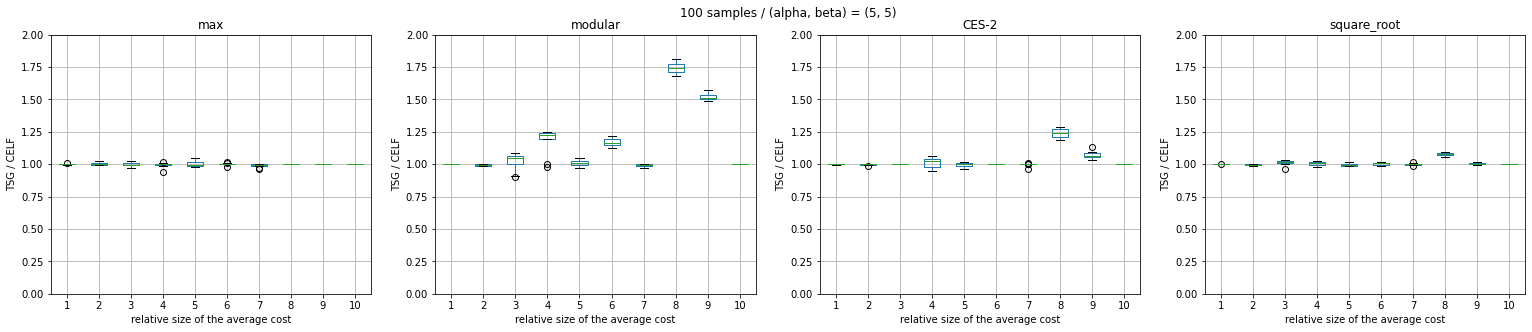

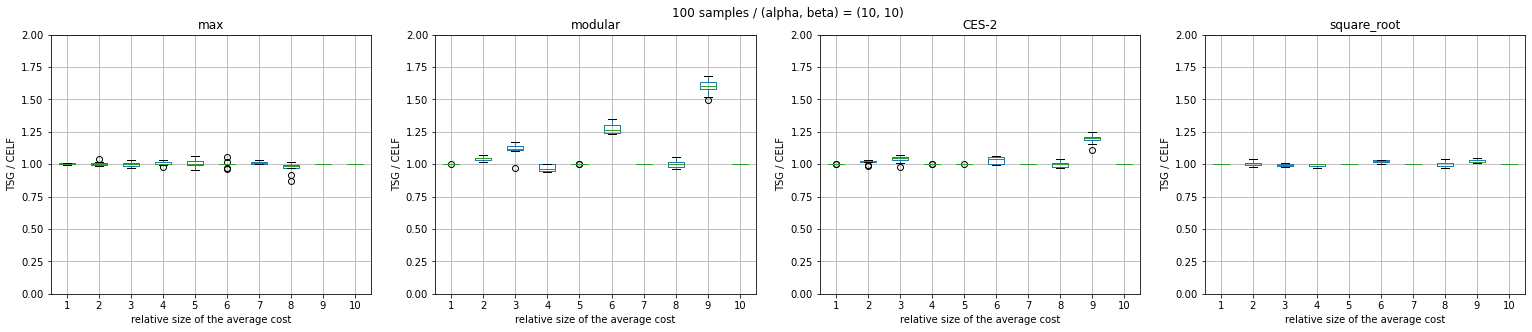

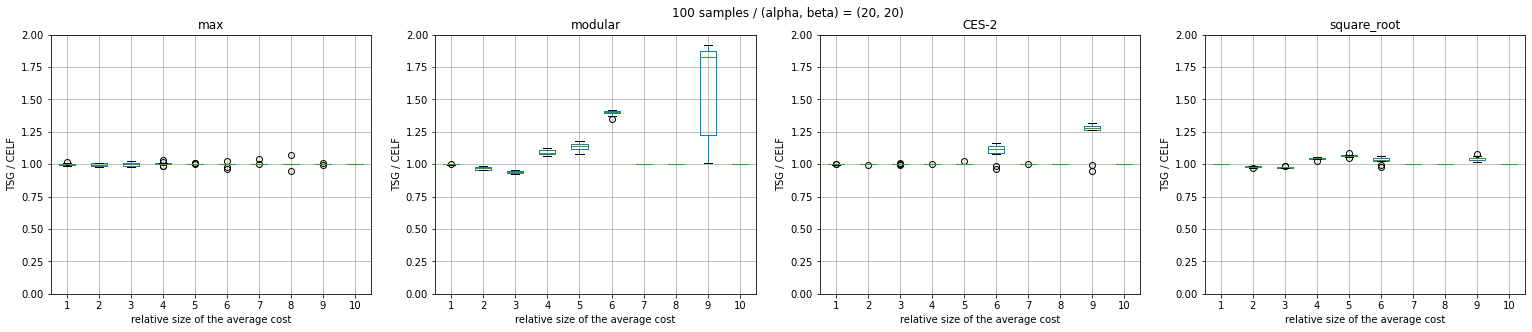

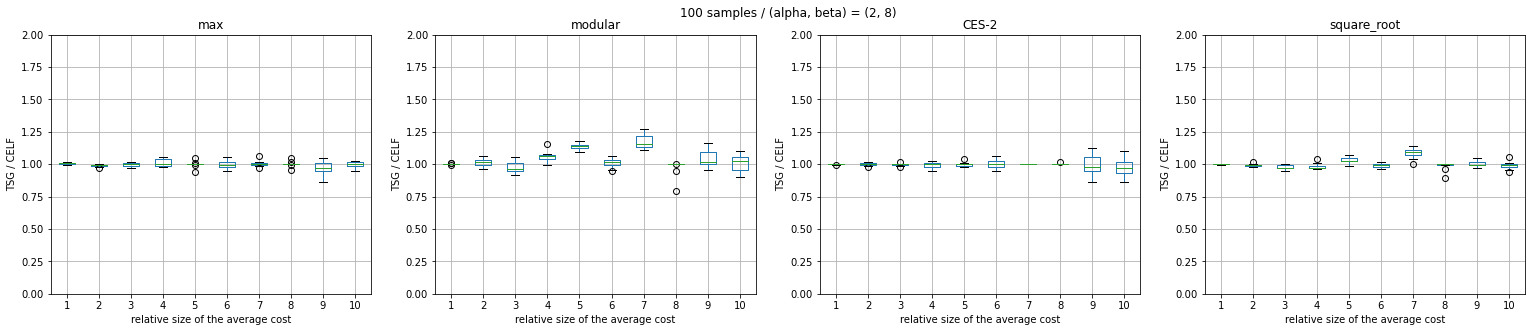

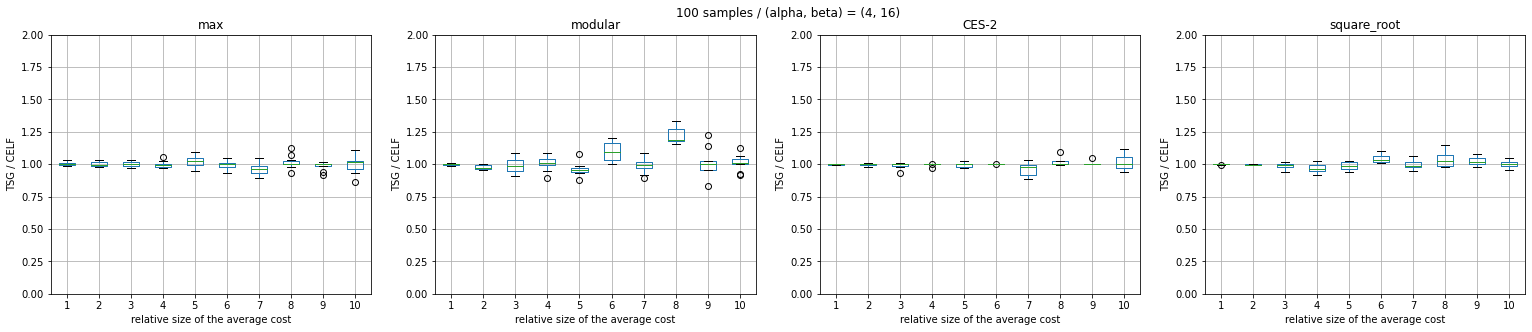

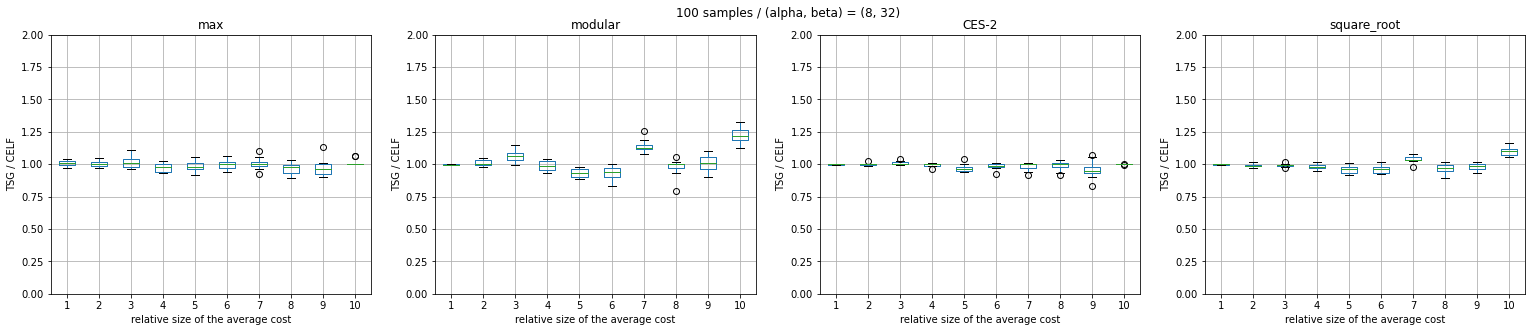

In [32]:
for alpha, beta in alpha_beta_pairs:
    boxplot_first(100, objs, 10, 10, alpha, beta)

### ($\alpha$, $\beta$)=(10, 10) fixed  + varying sample sizes

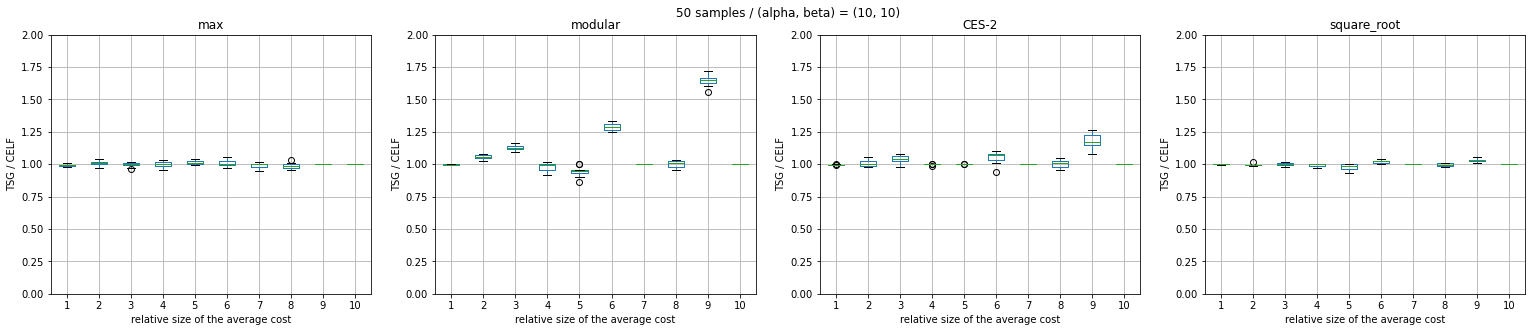

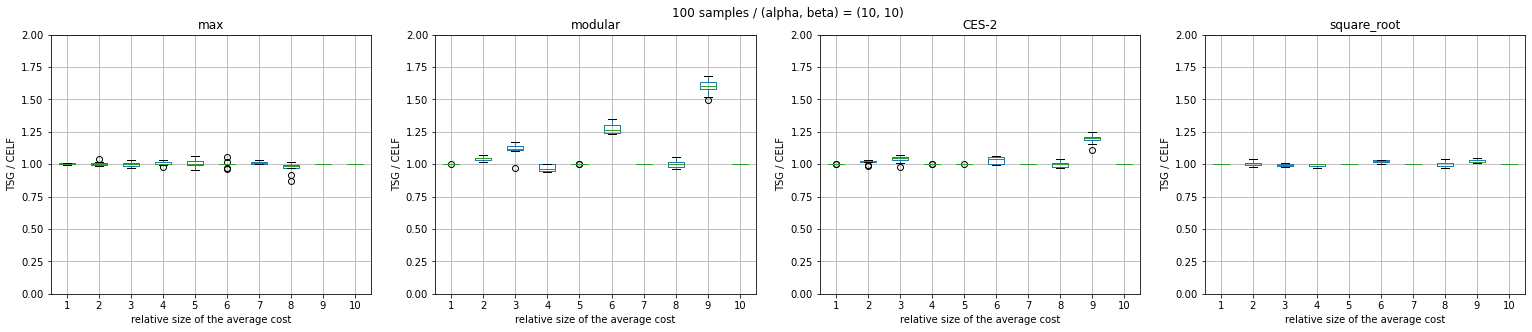

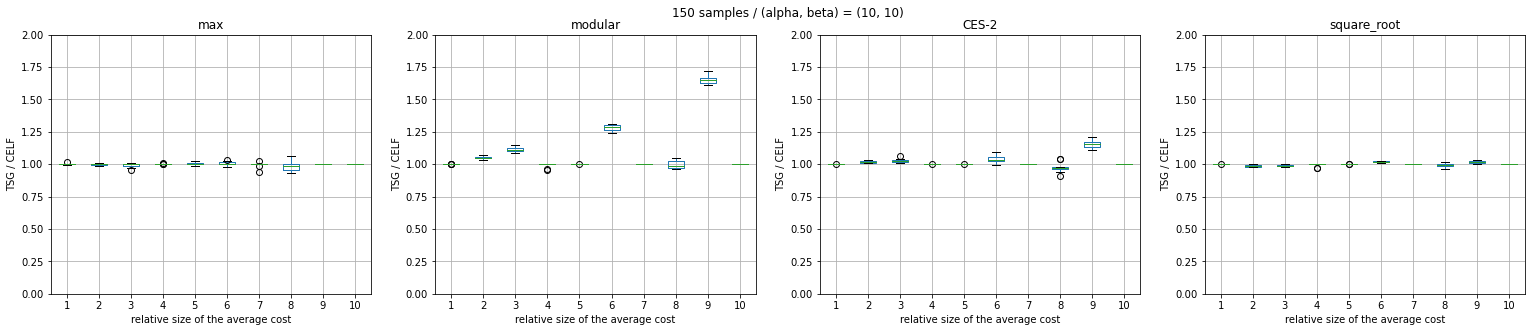

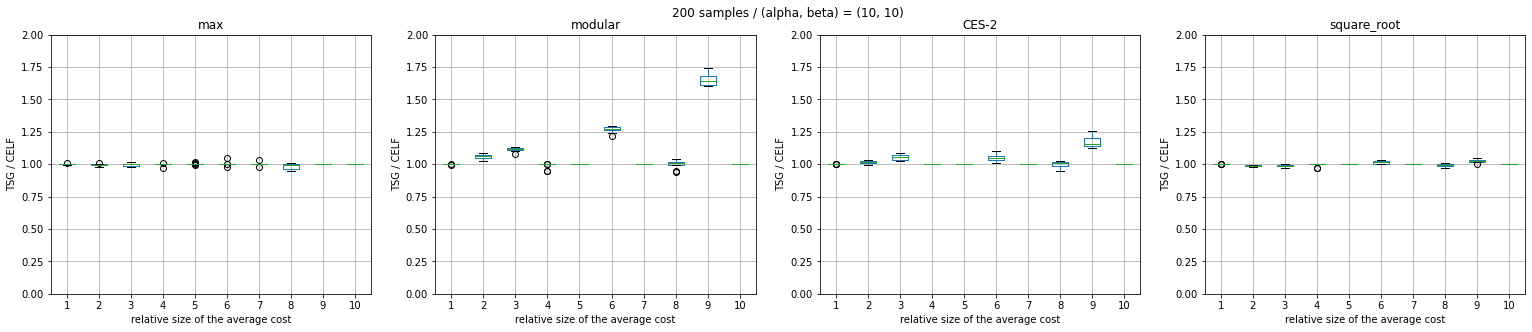

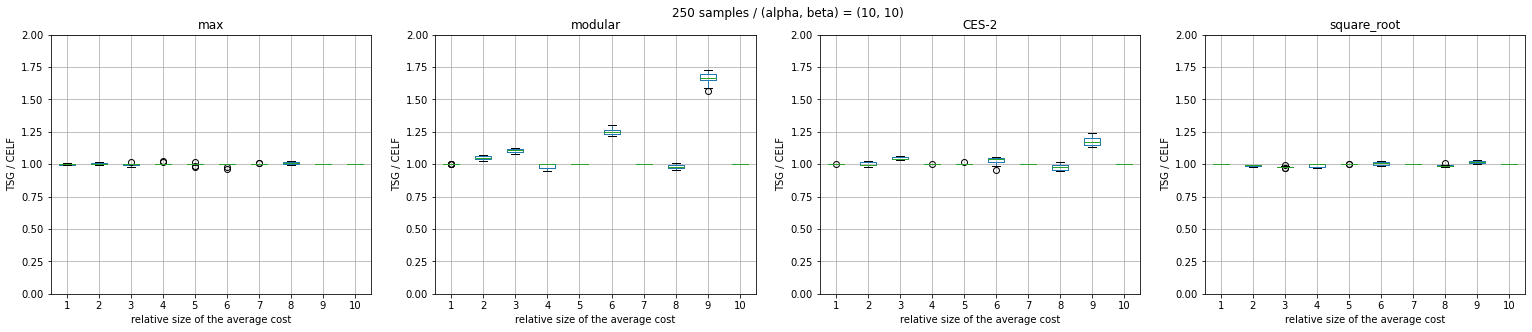

In [33]:
for n in training_sample_sizes:
    boxplot_first(n, objs, 10, 10, 10, 10)

# Average number of users selected

In [34]:
def number_of_users(num_training_samples, objs, num_setups, num_reps, alpha, beta):
    df = pd.read_csv('results/results_raw_data.csv')
        
    filt1 = (df['num_training_samples'] == num_training_samples) & (df['num_reps'] == num_reps)
    filt2 = (df['alpha'] == alpha) & (df['beta'] == beta)
    num_axes = len(objs)
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    for count, obj in enumerate(objs):
        filtered = df[filt1 & filt2 & (df['obj'] == obj)]
        filtered.boxplot(ax = axes[count], column = 'num_users_TSG', by = 'setup_number')
        axes[count].set_title(obj)
        axes[count].set_xlabel("relative size of the average cost")
        axes[count].set_ylabel("number of users selected")
        axes[count].set_ylim((0, 31))
        #axes[count].xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    substring = f'(alpha, beta) = ({alpha}, {beta})'
    fig.suptitle(str(num_training_samples) + ' samples / ' + substring)

In [35]:
def compare_number_of_users(num_training_samples, objs, num_setups, num_reps, alpha, beta):
    df = pd.read_csv('results/results_raw_data.csv')
        
    filt1 = (df['num_training_samples'] == num_training_samples) & (df['num_reps'] == num_reps)
    filt2 = (df['alpha'] == alpha) & (df['beta'] == beta)
    
    num_axes = len(objs)
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    for count, obj in enumerate(objs):
        
        filtered = df[filt1 & filt2 & (df['obj'] == obj)]
        filtered = filtered.rename(columns = {'num_users_TSG' : 'TSG', 'num_users_CELF': 'CELF'})
        size_data = pd.melt(filtered[['setup_number', 'TSG', 'CELF']], ['setup_number'])
        sns.lineplot(ax = axes[count], x='setup_number', y='value', hue='variable', data=size_data)
        
        #filtered.boxplot(ax = axes[count], column = 'num_employees', by = 'setup_number')
        axes[count].set_title(obj)
        axes[count].set_xlabel("relative size of the average cost")
        axes[count].set_ylabel("number of users selected")
        axes[count].set_ylim((0, 30))
        axes[count].grid()
        axes[count].legend()
        #axes[count].xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    substring = f'(alpha, beta) = ({alpha}, {beta})'
    fig.suptitle(str(num_training_samples) + ' samples / ' + substring)

### Fixed sample size (100 training samples) + varying ($\alpha$, $\beta$)

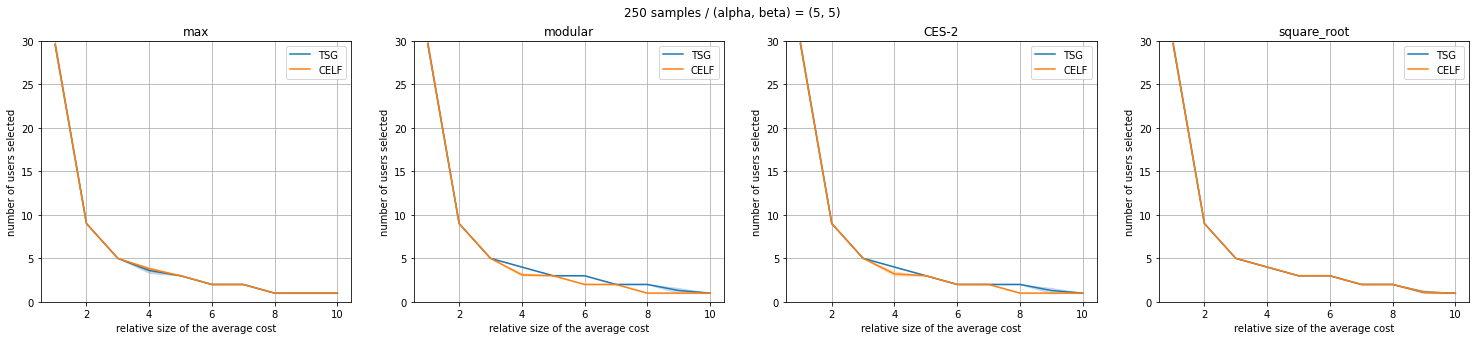

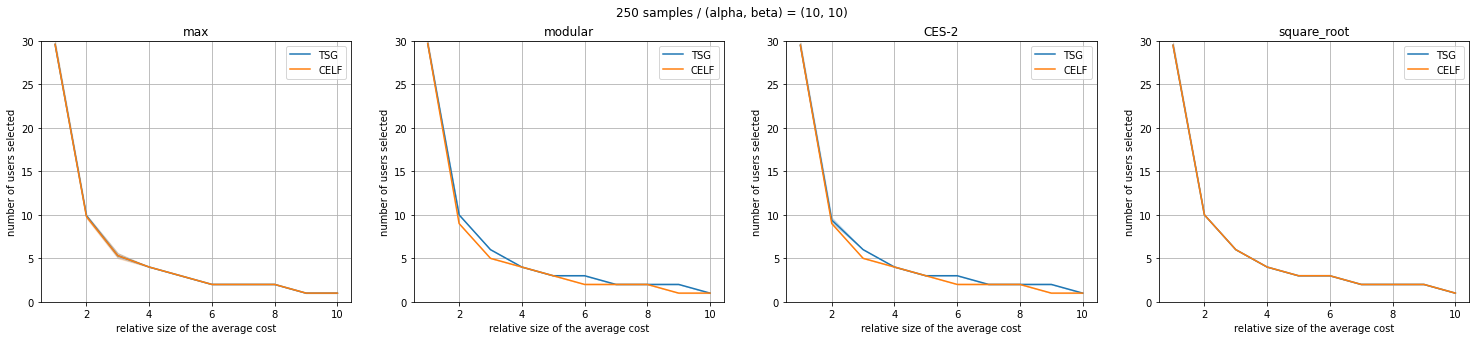

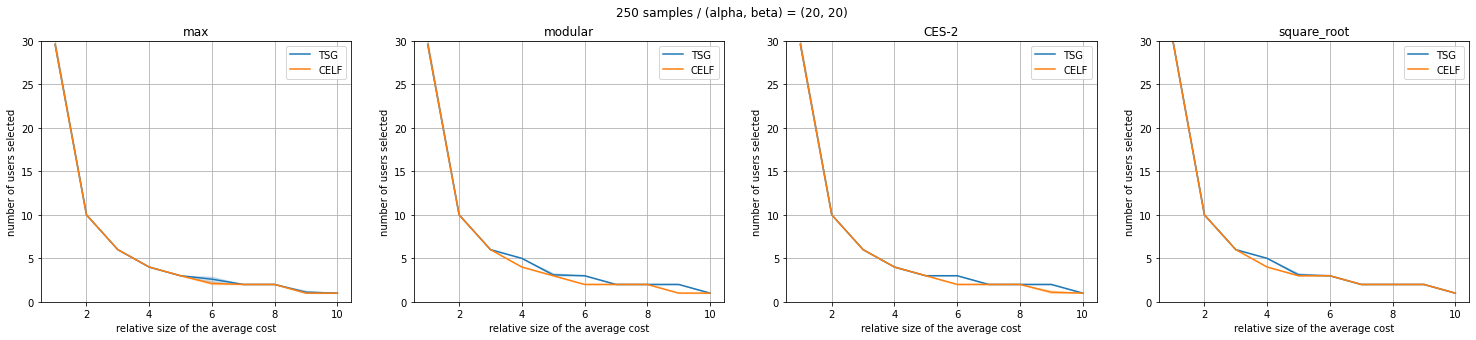

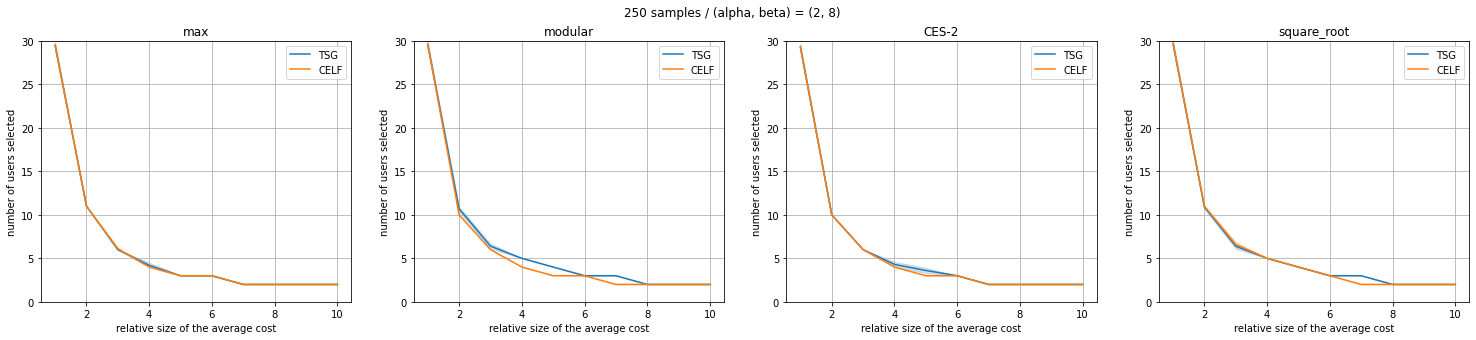

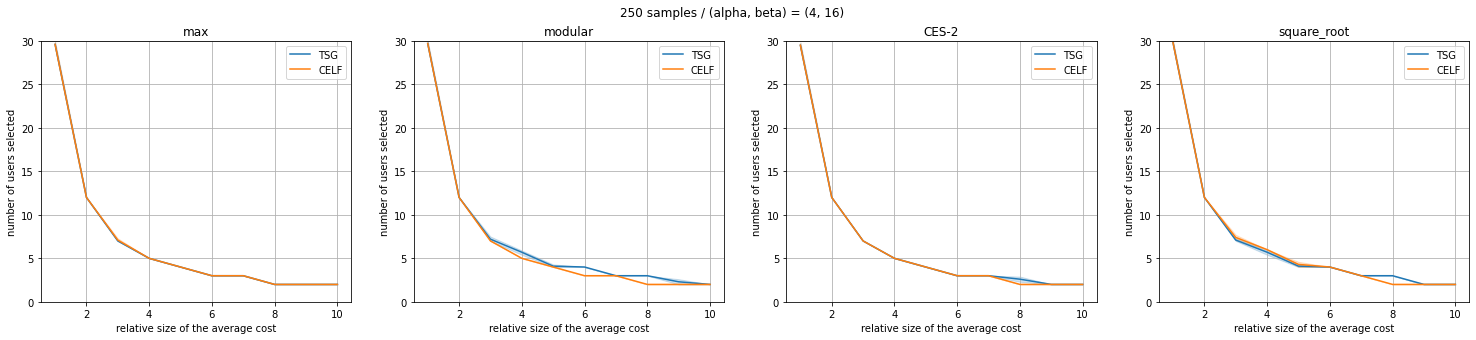

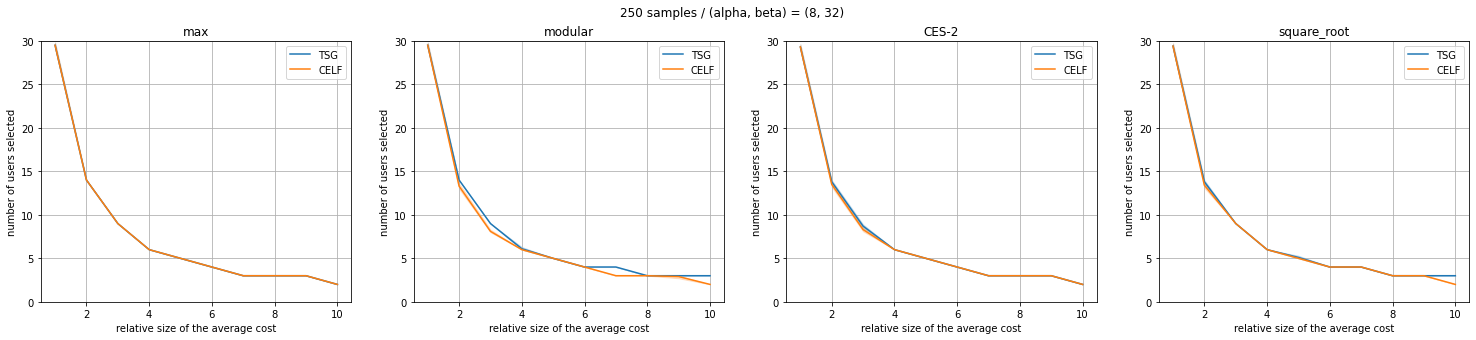

In [36]:
for alpha, beta in alpha_beta_pairs:
    compare_number_of_users(n, objs, 10, 10, alpha, beta)

### ($\alpha$, $\beta$)=(10, 10) fixed  + varying sample sizes

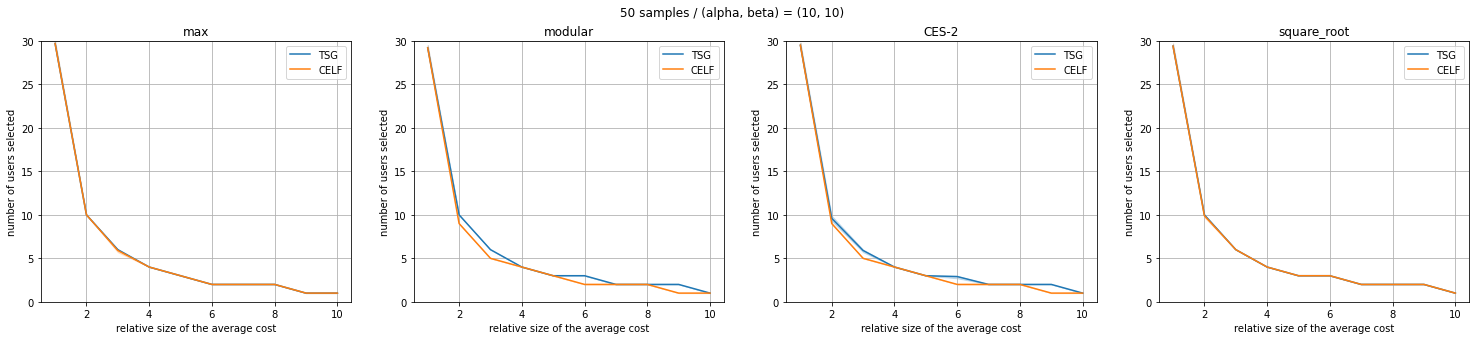

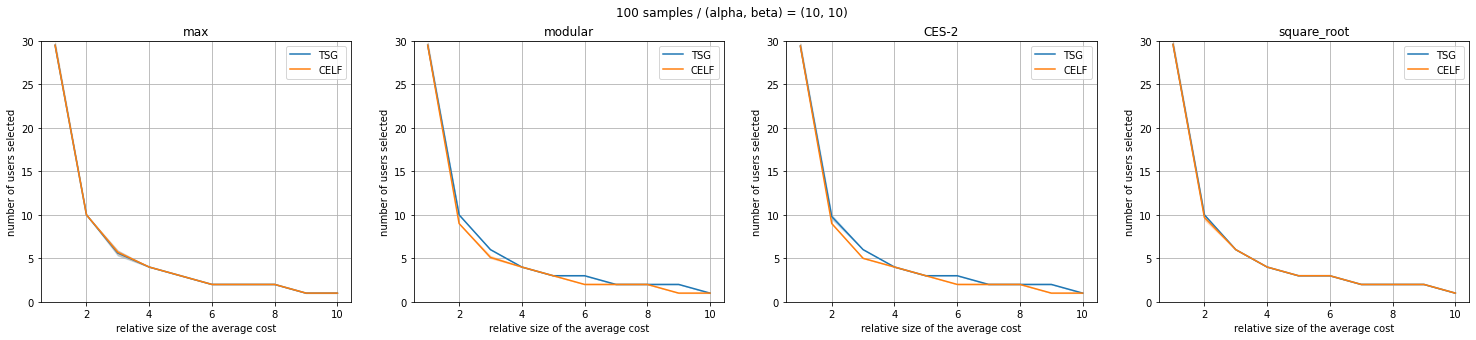

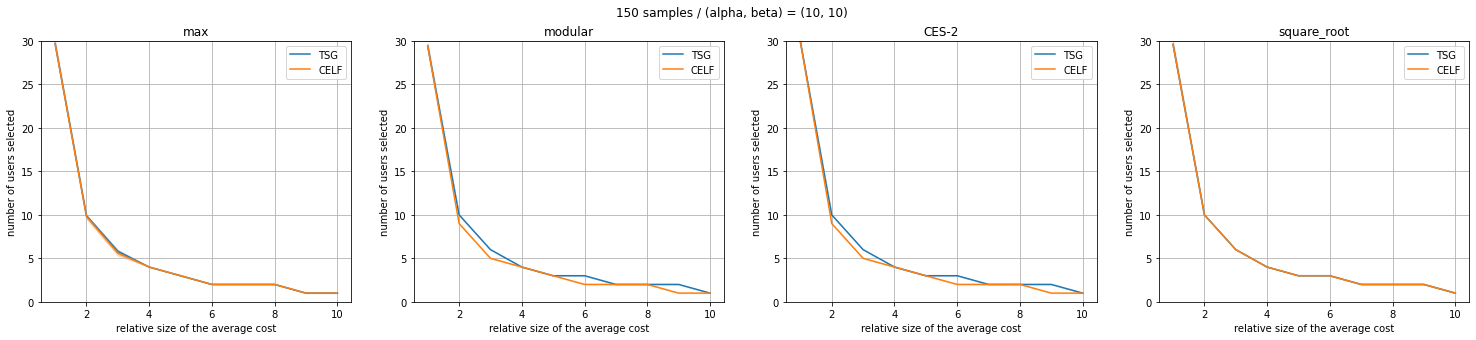

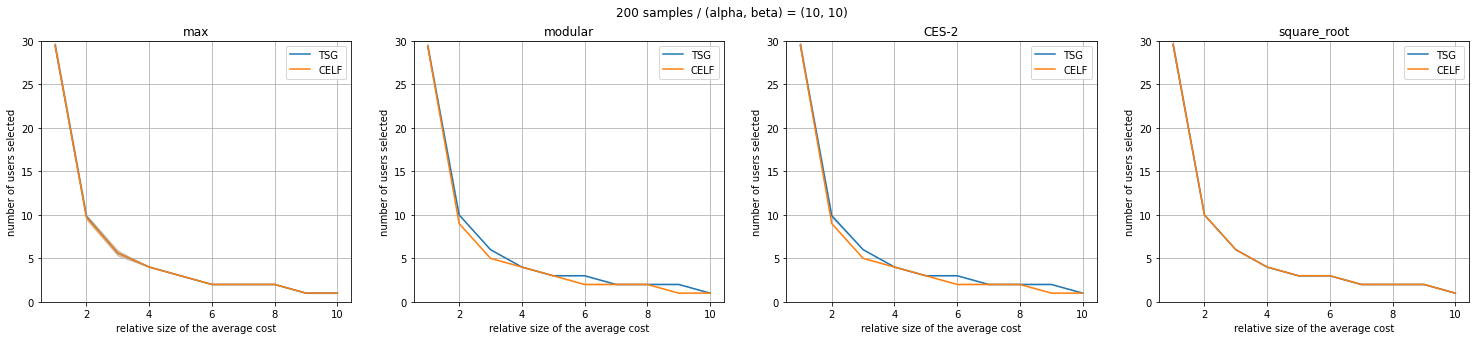

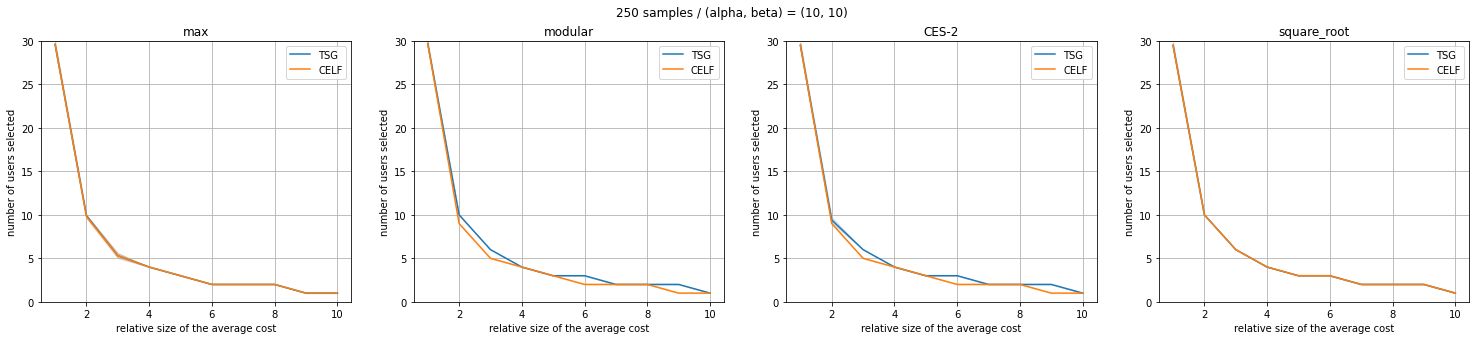

In [37]:
for n in training_sample_sizes:
    compare_number_of_users(n, objs, 10, 10, 10, 10)